# Load Dataset and Libraries

In [32]:
# Load Dataset and Libraries

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import scipy.stats as ss
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,RocCurveDisplay, classification_report,confusion_matrix, log_loss
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeClassifier
from sklearn import linear_model 
from IPython.display import display
import warnings
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import class_weight
from sklearn.ensemble import BaggingClassifier

In [34]:
df = pd.read_csv('./data/Guns incident Data.csv')
df.head()

,S.No.,Year,Month,Date,Reason,Education,Sex,Age,Race,Hispanic,Place of incident,Police involvement
0,1,2017,1,06-01-2017,Suicide,Bachelors,Male,35.0,Asian/Pacific Islander,100,Home,0
1,2,2017,1,19-01-2017,Suicide,Some college,Female,22.0,White,100,Street,0
2,3,2017,1,01-01-2017,Suicide,Bachelors,Male,61.0,White,100,Other specified,0
3,4,2017,2,06-02-2017,Suicide,Bachelors,Male,65.0,White,100,Home,0
4,5,2017,2,09-02-2017,Suicide,High School,Male,32.0,White,100,Other specified,0


# Data Cleaning

In [35]:
'''Drop columns S.No., Date, Hispanic; insert Reason as the first column.'''
df_clean = df.drop(['S.No.', 'Date', 'Hispanic'], axis=1)
df_clean.insert(0, 'Reason', df_clean.pop('Reason'))
df_clean.head()

,Reason,Year,Month,Education,Sex,Age,Race,Place of incident,Police involvement
0,Suicide,2017,1,Bachelors,Male,35.0,Asian/Pacific Islander,Home,0
1,Suicide,2017,1,Some college,Female,22.0,White,Street,0
2,Suicide,2017,1,Bachelors,Male,61.0,White,Other specified,0
3,Suicide,2017,2,Bachelors,Male,65.0,White,Home,0
4,Suicide,2017,2,High School,Male,32.0,White,Other specified,0


## Data Quality Check

In [36]:
''' Check percentage of missing values in each variable '''

na_percentage = df_clean.isna().sum() / df.shape[0] * 100

na_percentage = na_percentage.round(2)
print("Percentage of NaN values for each variable:")
print(na_percentage)

Percentage of NaN values for each variable:
Reason                0.00
Year                  0.00
Month                 0.00
Education             1.41
Sex                   0.00
Age                   0.02
Race                  0.00
Place of incident     1.37
Police involvement    0.00
dtype: float64


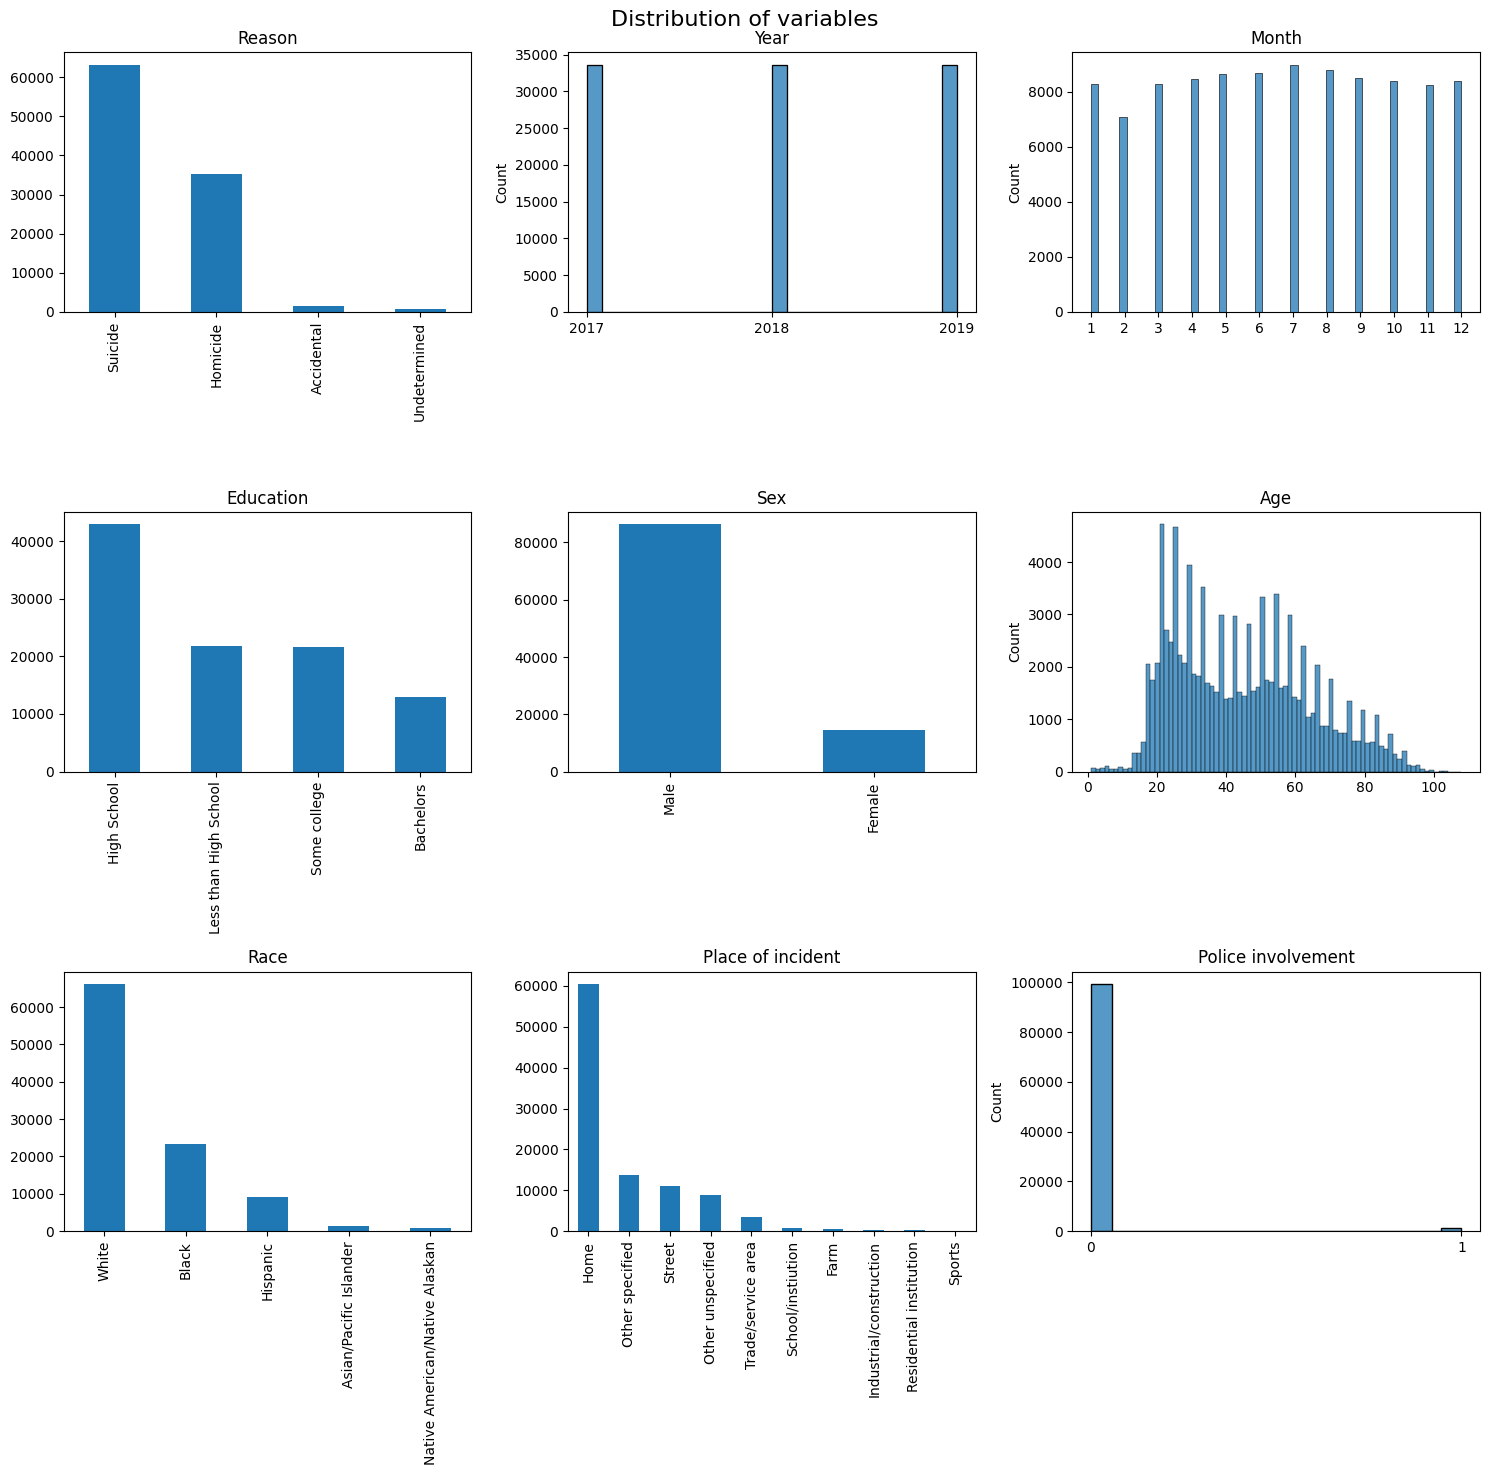

In [37]:
'''Plot distribution of all variables'''
#checking for class imbalance

discrete_numerical_var = ['Year','Month','Police involvement']
continuous_numerical_var = ['Age']
categorical_var = ['Education','Sex','Race','Place of incident','Reason']

#plt.style.use('seaborn')
fig,axs = plt.subplots(3,3, figsize=(15,15))
fig.suptitle('Distribution of variables', fontsize = 16)
idx = 0

for i in range(3):
  for j in range(3):
    var = df_clean.columns[idx]
    if var in discrete_numerical_var:
      sns.histplot(data = df, x = var, ax=axs[i,j])
      axs[i, j].set_xticks(range(min(df[var]),max(df[var])+1,1))
    elif var in continuous_numerical_var:
      sns.histplot(data = df, x = var, ax=axs[i,j])
    else:
      df[var].value_counts().plot(kind='bar', ax=axs[i,j])
    axs[i,j].set_xlabel('')
    axs[i,j].set_title(var)
    idx += 1

plt.tight_layout()

In [38]:
#Proportion of classes in target variable

proportion_table = df_clean['Reason'].value_counts(normalize=True).reset_index()

proportion_table.columns = ['Reason', 'Proportion']

proportion_table['Proportion'] = proportion_table['Proportion'] * 100

print(proportion_table)

         Reason  Proportion
0       Suicide   62.674855
1      Homicide   34.897518
2    Accidental    1.626024
3  Undetermined    0.801603


# Exploratory Data Analysis

### Proportions of Race for each Reason

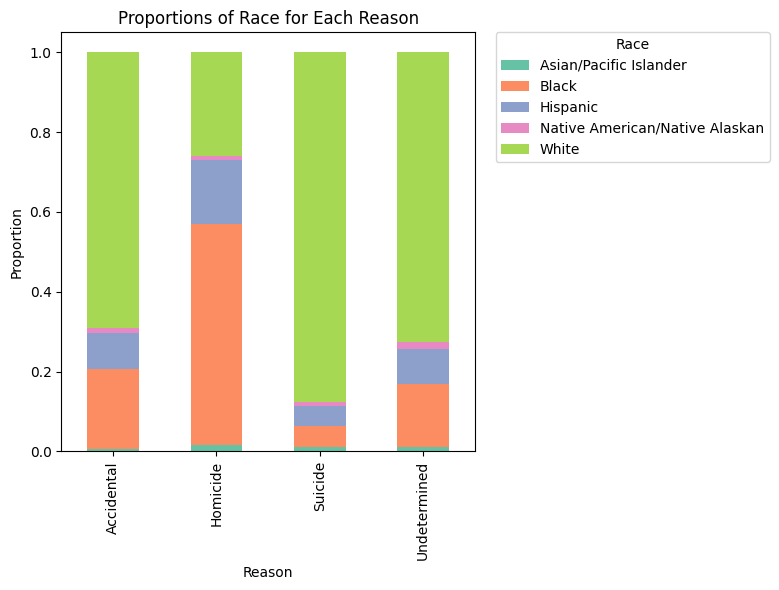

In [39]:
crosstab = pd.crosstab(df_clean['Reason'], df_clean['Race'], normalize='index')

colors = sns.color_palette("Set2", n_colors=len(crosstab.columns))
ax = crosstab.plot(kind='bar', stacked=True, figsize=(8, 6), color=colors)

plt.xlabel('Reason')
plt.ylabel('Proportion')
plt.title('Proportions of Race for Each Reason')

plt.legend(title='Race', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()


White individuals are the majority class for Suicide, Accidental and Undetermined incidents. However, for Homicide, there is a higher proportion of black individuals involved. This variability suggests that the race of the individual could influence the cause of gun incidents.

### Proportions of Education for each Reason

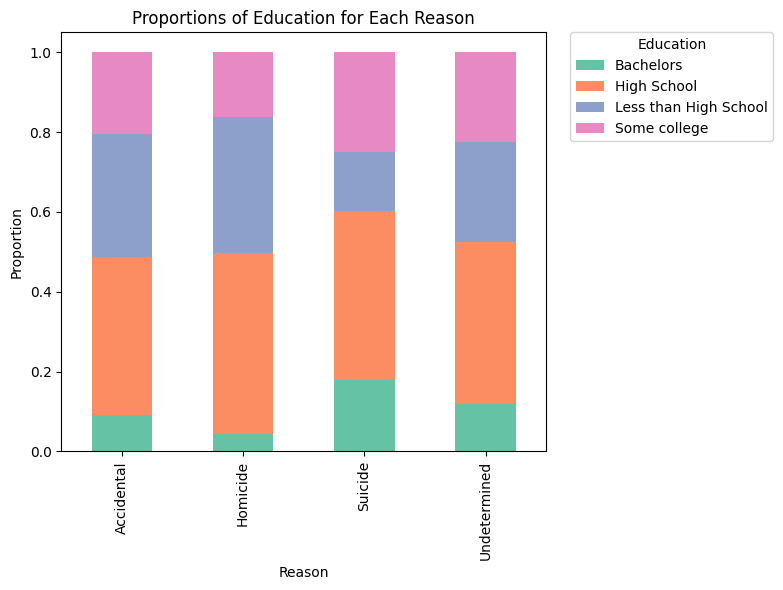

In [40]:
crosstab = pd.crosstab(df_clean['Reason'], df_clean['Education'], normalize='index')

colors = sns.color_palette("Set2", n_colors=len(crosstab.columns))
ax = crosstab.plot(kind='bar', stacked=True, figsize=(8, 6), color=colors)

plt.xlabel('Reason')
plt.ylabel('Proportion')
plt.title('Proportions of Education for Each Reason')

plt.legend(title='Education', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()

The stacked bar plot suggests that suicide cases involved a higher proportion of invidiausl who have completed their bachelors, and a lower proportion of individuals who did not complete high school. There are noticeable differences between the proportion of education across different reasons.

### Proportions of Sex for each Reason

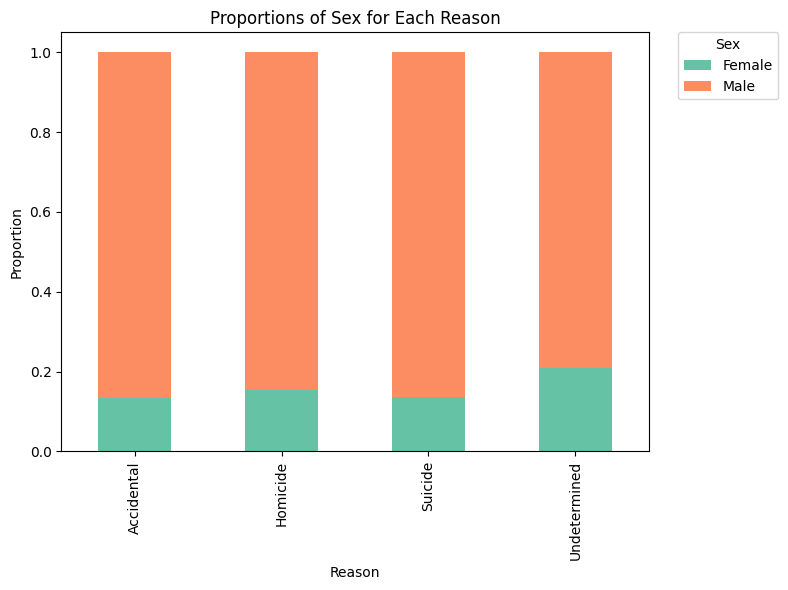

In [64]:
crosstab = pd.crosstab(df_clean['Reason'], df_clean['Sex'], normalize='index')

colors = sns.color_palette("Set2", n_colors=len(crosstab.columns))
ax = crosstab.plot(kind='bar', stacked=True, figsize=(8, 6), color=colors)

plt.xlabel('Reason')
plt.ylabel('Proportion')
plt.title('Proportions of Sex for Each Reason')

plt.legend(title='Sex', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()

The proportion of sex is similar across all reasons, though gun incidents with undetermined cause have a higher proportion of female individuals.

### Proportions of Place of incident for each Reason

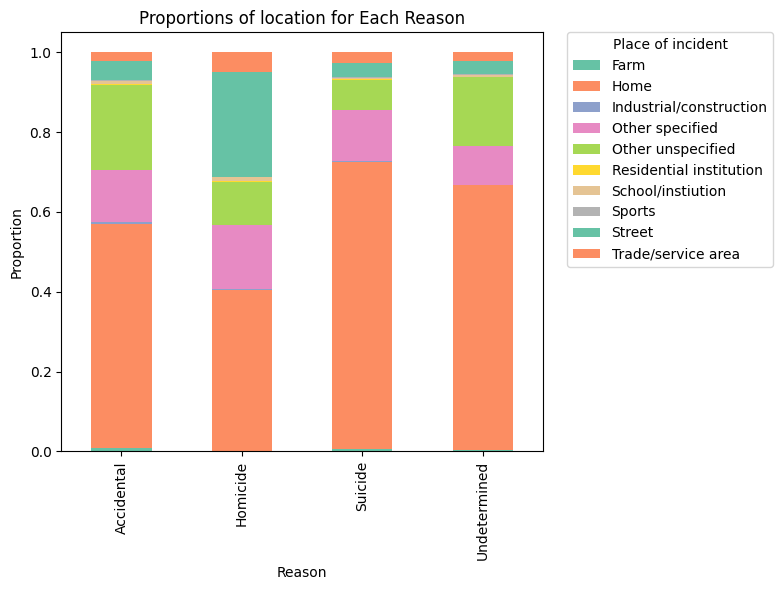

In [65]:
crosstab = pd.crosstab(df_clean['Reason'], df_clean['Place of incident'], normalize='index')

colors = sns.color_palette("Set2", n_colors=len(crosstab.columns))
ax = crosstab.plot(kind='bar', stacked=True, figsize=(8, 6), color=colors)

plt.xlabel('Reason')
plt.ylabel('Proportion')
plt.title('Proportions of location for Each Reason')

plt.legend(title='Place of incident', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()

Across all Reasons, Trade/service area is the most common place of incident. However, for homicide cases, there are more cases of gun incidents in farms compared to other reasons.

### Proportions of Police Involvement for each Reason

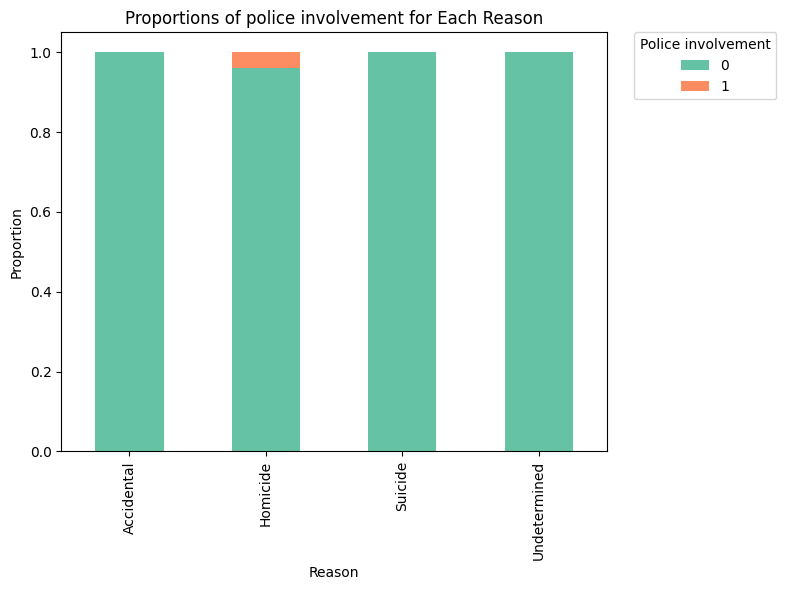

In [43]:
crosstab = pd.crosstab(df_clean['Reason'], df_clean['Police involvement'], normalize='index')

colors = sns.color_palette("Set2", n_colors=len(crosstab.columns))
ax = crosstab.plot(kind='bar', stacked=True, figsize=(8, 6), color=colors)

plt.xlabel('Reason')
plt.ylabel('Proportion')
plt.title('Proportions of police involvement for Each Reason')

plt.legend(title='Police involvement', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()


We infer that police are only involved in Homicide incidents.

### Distribution of Age for each Reason

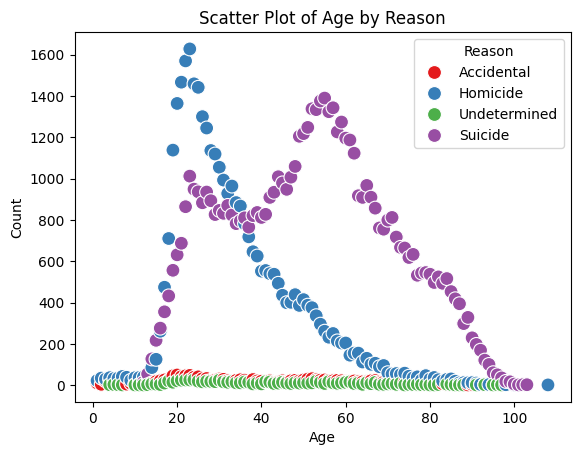

In [44]:
age_reason_count = df_clean.groupby(['Age', 'Reason']).size().reset_index(name='count')
sns.scatterplot(data=age_reason_count, x='Age', y='count', hue='Reason', palette='Set1', s=100)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Scatter Plot of Age by Reason')

plt.legend(title='Reason')
plt.show()


There is a distinct trend curve between Age and the two majority classes (Homicide and Suicide). Therefore, it is likely that age of an individual have an influence on the type of incident they are involved in.

In conclusion, we believe that Race and Age will be the more important features influencing the classification model.

# Data Pre-processing

## Split into Train and Test Data

In [45]:
''' 80-20 ratio used, 80% data used for training, 20% used for testing '''
df_clean_train, df_clean_test = train_test_split(df_clean, test_size=0.2, random_state=42)

## Data Manipulation for Train Data

### Dealing with Missing Data

In [46]:
'''Check number of rows and columns with missing data'''
rows_with_missing = df_clean_train[df_clean_train.isnull().any(axis=1)]
print(rows_with_missing.shape)
columns_with_missing = df_clean_train.columns[df_clean_train.isnull().any()]
print(columns_with_missing)

(2222, 9)
Index(['Education', 'Age', 'Place of incident'], dtype='object')


#### Remove Missing Data from Train Data

In [47]:
df_clean_train_rem = df_clean_train.dropna()

#### Impute Missing Data from Train Data

In [48]:
# Impute ALL Missing Values
df_clean_train_imp = df_clean_train.copy()

# Age
age_imputer = SimpleImputer(strategy='median')
df_clean_train_imp['Age'] = age_imputer.fit_transform(df_clean_train_imp[['Age']])

# Education
education_counts = df_clean_train_imp['Education'].value_counts(normalize=True)
education_categories = education_counts.index.tolist()
education_probs = education_counts.values

np.random.seed(1)

df_clean_train_imp['Education'] = df_clean_train_imp['Education'].apply(
    lambda x: np.random.choice(education_categories, p = education_probs) if pd.isnull(x) else x
)

# Place of incident
place_counts = df_clean_train_imp['Place of incident'].value_counts(normalize=True)
place_categories = place_counts.index.tolist()
place_probs = place_counts.values

np.random.seed(1)

df_clean_train_imp['Place of incident'] = df_clean_train_imp['Place of incident'].apply(
    lambda x: np.random.choice(place_categories, p=place_probs) if pd.isnull(x) else x
)

### Encoding

#### Encode train data where missing values are **removed** ###

In [49]:
cleanup_nums = {"Education":     {"Less than High School": 0, "High School": 1,"Some college":2,"Bachelors":3}}       
df_clean_train_rem = df_clean_train_rem.replace(cleanup_nums)

#one hot encoding for gender
gender_ohe=pd.get_dummies(df_clean_train_rem.Sex) #gender one hot encoding
dftemp=df_clean_train_rem
dftemp=dftemp.drop(columns=["Sex"])
dftemp=pd.concat([gender_ohe,dftemp],axis=1)

#one hot encoding for race
race_ohe=pd.get_dummies(df_clean_train_rem.Race) #race one hot encoding
dftemp=dftemp.drop(columns=["Race"])
dftemp=pd.concat([race_ohe,dftemp],axis=1)

#one hot encoding for place of incident
place_ohe=pd.get_dummies(df_clean_train_rem["Place of incident"]) #place one hot encoding
dftemp=dftemp.drop(columns=["Place of incident"])
dftemp= pd.concat([place_ohe,dftemp],axis=1)

df_clean_train_remecd = dftemp


#### Encode train data where missing values are **imputed** ###

In [50]:
df_clean_train_imp = df_clean_train_imp.replace(cleanup_nums)

#one hot encoding for gender
gender_ohe=pd.get_dummies(df_clean_train_imp.Sex) #gender one hot encoding
dftemp=df_clean_train_imp
dftemp=dftemp.drop(columns=["Sex"])
dftemp=pd.concat([gender_ohe,dftemp],axis=1)

#one hot encoding for race
race_ohe=pd.get_dummies(df_clean_train_imp.Race) #race one hot encoding
dftemp=dftemp.drop(columns=["Race"])
dftemp=pd.concat([race_ohe,dftemp],axis=1)

#one hot encoding for place of incident
place_ohe=pd.get_dummies(df_clean_train_imp["Place of incident"]) #place one hot encoding
dftemp=dftemp.drop(columns=["Place of incident"])
dftemp= pd.concat([place_ohe,dftemp],axis=1)

df_clean_train_impecd = dftemp
df_train_final_imb = dftemp

### Resampling Under-represented Classes

#### Resample train data where missing values are **removed**

In [51]:
#df_clean_train_remecd['Reason'].value_counts(), majority class for imputed training data is suicide 
mclass_len = df_clean_train_remecd[df_clean_train_remecd['Reason']=='Suicide'].shape[0]
'''underrepresented classes are homicide, accidental, undetermined with majority class suicide having 49818 rows '''

majority_class_suicide = df_clean_train_remecd[df_clean_train_remecd['Reason']=='Suicide']
minority_class_homicide = df_clean_train_remecd[df_clean_train_remecd['Reason']=='Homicide']
minority_class_accidental = df_clean_train_remecd[df_clean_train_remecd['Reason']=='Accidental']
minority_class_undetermined= df_clean_train_remecd[df_clean_train_remecd['Reason']=='Undetermined']

df_cr_oversamp_hom = resample(minority_class_homicide, replace=True, n_samples = mclass_len, random_state=4) #df_cleanremove_...
df_cr_oversamp_acc = resample(minority_class_accidental, replace=True, n_samples = mclass_len, random_state=4)
df_cr_oversamp_und = resample(minority_class_undetermined, replace=True, n_samples = mclass_len, random_state=4)

df_train_final_rem= pd.concat([majority_class_suicide,df_cr_oversamp_hom,df_cr_oversamp_acc, df_cr_oversamp_und])
df_train_final_rem.head()

,Farm,Home,Industrial/construction,Other specified,Other unspecified,Residential institution,School/instiution,Sports,Street,Trade/service area,...,Native American/Native Alaskan,White,Female,Male,Reason,Year,Month,Education,Age,Police involvement
93874,False,True,False,False,False,False,False,False,False,False,...,False,True,True,False,Suicide,2019,2,2,69.0,0
8119,False,True,False,False,False,False,False,False,False,False,...,False,True,False,True,Suicide,2017,8,0,77.0,0
3211,False,True,False,False,False,False,False,False,False,False,...,False,True,False,True,Suicide,2017,4,1,46.0,0
65943,False,False,False,True,False,False,False,False,False,False,...,False,True,False,True,Suicide,2018,11,3,60.0,0
29973,False,True,False,False,False,False,False,False,False,False,...,False,False,False,True,Suicide,2017,11,0,31.0,0


#### Resample train data where missing values are **imputed**

In [52]:
#df_clean_train_remecd['Reason'].value_counts(), majority class for imputed training data is suicide 
mclass_len = df_clean_train_remecd[df_clean_train_remecd['Reason']=='Suicide'].shape[0]
'''underrepresented classes are homicide, accidental, undetermined with majority class suicide having 49818 rows '''

majority_class_suicide = df_clean_train_remecd[df_clean_train_remecd['Reason']=='Suicide']
minority_class_homicide = df_clean_train_remecd[df_clean_train_remecd['Reason']=='Homicide']
minority_class_accidental = df_clean_train_remecd[df_clean_train_remecd['Reason']=='Accidental']
minority_class_undetermined= df_clean_train_remecd[df_clean_train_remecd['Reason']=='Undetermined']

df_cr_oversamp_hom = resample(minority_class_homicide, replace=True, n_samples = mclass_len, random_state=4) #df_cleanremove_...
df_cr_oversamp_acc = resample(minority_class_accidental, replace=True, n_samples = mclass_len, random_state=4)
df_cr_oversamp_und = resample(minority_class_undetermined, replace=True, n_samples = mclass_len, random_state=4)

df_train_final_rem= pd.concat([majority_class_suicide,df_cr_oversamp_hom,df_cr_oversamp_acc, df_cr_oversamp_und])
df_train_final_rem.head()

,Farm,Home,Industrial/construction,Other specified,Other unspecified,Residential institution,School/instiution,Sports,Street,Trade/service area,...,Native American/Native Alaskan,White,Female,Male,Reason,Year,Month,Education,Age,Police involvement
93874,False,True,False,False,False,False,False,False,False,False,...,False,True,True,False,Suicide,2019,2,2,69.0,0
8119,False,True,False,False,False,False,False,False,False,False,...,False,True,False,True,Suicide,2017,8,0,77.0,0
3211,False,True,False,False,False,False,False,False,False,False,...,False,True,False,True,Suicide,2017,4,1,46.0,0
65943,False,False,False,True,False,False,False,False,False,False,...,False,True,False,True,Suicide,2018,11,3,60.0,0
29973,False,True,False,False,False,False,False,False,False,False,...,False,False,False,True,Suicide,2017,11,0,31.0,0


#### Resample train data where missing values are **imputed**

In [53]:
#df_clean_train_impecd['Reason'].value_counts(), majority class for imputed training data is suicide 
mclass_len = df_clean_train_impecd[df_clean_train_impecd['Reason']=='Suicide'].shape[0]
'''underrepresented classes are homicide, accidental, undetermined
with majority class suicide having 50580 rows '''

majority_class_suicide = df_clean_train_impecd[df_clean_train_impecd['Reason']=='Suicide']
minority_class_homicide = df_clean_train_impecd[df_clean_train_impecd['Reason']=='Homicide']
minority_class_accidental = df_clean_train_impecd[df_clean_train_impecd['Reason']=='Accidental']
minority_class_undetermined= df_clean_train_impecd[df_clean_train_impecd['Reason']=='Undetermined']

df_ci_oversamp_hom = resample(minority_class_homicide, replace=True, n_samples = mclass_len, random_state=42)
df_ci_oversamp_acc = resample(minority_class_accidental, replace=True, n_samples = mclass_len, random_state=42)
df_ci_oversamp_und = resample(minority_class_undetermined, replace=True, n_samples = mclass_len, random_state=42)

df_train_final_imp= pd.concat([majority_class_suicide,df_ci_oversamp_hom,df_ci_oversamp_acc, df_ci_oversamp_und])
df_train_final_imp.head()

,Farm,Home,Industrial/construction,Other specified,Other unspecified,Residential institution,School/instiution,Sports,Street,Trade/service area,...,Native American/Native Alaskan,White,Female,Male,Reason,Year,Month,Education,Age,Police involvement
93874,False,True,False,False,False,False,False,False,False,False,...,False,True,True,False,Suicide,2019,2,2,69.0,0
8119,False,True,False,False,False,False,False,False,False,False,...,False,True,False,True,Suicide,2017,8,0,77.0,0
3211,False,True,False,False,False,False,False,False,False,False,...,False,True,False,True,Suicide,2017,4,1,46.0,0
65943,False,False,False,True,False,False,False,False,False,False,...,False,True,False,True,Suicide,2018,11,3,60.0,0
29973,False,True,False,False,False,False,False,False,False,False,...,False,False,False,True,Suicide,2017,11,0,31.0,0


#### Resample train data where missing values are **imputed**

In [54]:
#df_clean_train_impecd['Reason'].value_counts(), majority class for imputed training data is suicide 
mclass_len = df_clean_train_impecd[df_clean_train_impecd['Reason']=='Suicide'].shape[0]
'''underrepresented classes are homicide, accidental, undetermined
with majority class suicide having 50580 rows '''

majority_class_suicide = df_clean_train_impecd[df_clean_train_impecd['Reason']=='Suicide']
minority_class_homicide = df_clean_train_impecd[df_clean_train_impecd['Reason']=='Homicide']
minority_class_accidental = df_clean_train_impecd[df_clean_train_impecd['Reason']=='Accidental']
minority_class_undetermined= df_clean_train_impecd[df_clean_train_impecd['Reason']=='Undetermined']

df_ci_oversamp_hom = resample(minority_class_homicide, replace=True, n_samples = mclass_len, random_state=42)
df_ci_oversamp_acc = resample(minority_class_accidental, replace=True, n_samples = mclass_len, random_state=42)
df_ci_oversamp_und = resample(minority_class_undetermined, replace=True, n_samples = mclass_len, random_state=42)

df_train_final_imp= pd.concat([majority_class_suicide,df_ci_oversamp_hom,df_ci_oversamp_acc, df_ci_oversamp_und])
df_train_final_imp.head()

,Farm,Home,Industrial/construction,Other specified,Other unspecified,Residential institution,School/instiution,Sports,Street,Trade/service area,...,Native American/Native Alaskan,White,Female,Male,Reason,Year,Month,Education,Age,Police involvement
93874,False,True,False,False,False,False,False,False,False,False,...,False,True,True,False,Suicide,2019,2,2,69.0,0
8119,False,True,False,False,False,False,False,False,False,False,...,False,True,False,True,Suicide,2017,8,0,77.0,0
3211,False,True,False,False,False,False,False,False,False,False,...,False,True,False,True,Suicide,2017,4,1,46.0,0
65943,False,False,False,True,False,False,False,False,False,False,...,False,True,False,True,Suicide,2018,11,3,60.0,0
29973,False,True,False,False,False,False,False,False,False,False,...,False,False,False,True,Suicide,2017,11,0,31.0,0


## Data Manipulation for Test Data

### Dealing with Missing Data

In [55]:
'''Check number of rows and columns with missing data'''
rows_with_missing = df_clean_test[df_clean_test.isnull().any(axis=1)]
print(rows_with_missing.shape)
columns_with_missing = df_clean_test.columns[df_clean_test.isnull().any()]
print(columns_with_missing)

(561, 9)
Index(['Education', 'Age', 'Place of incident'], dtype='object')


#### Remove Missing Data from Test Data

In [56]:
df_clean_test_rem = df_clean_test.dropna()

#### Impute Missing Data from Test Data

In [57]:
# Impute ALL Missing Values
df_clean_test_imp = df_clean_test.copy()

# Age
age_imputer = SimpleImputer(strategy='median')
df_clean_test_imp['Age'] = age_imputer.fit_transform(df_clean_test_imp[['Age']])

# Education
education_counts = df_clean_test_imp['Education'].value_counts(normalize=True)
education_categories = education_counts.index.tolist()
education_probs = education_counts.values

np.random.seed(1)

df_clean_test_imp['Education'] = df_clean_test_imp['Education'].apply(
    lambda x: np.random.choice(education_categories, p = education_probs) if pd.isnull(x) else x
)

# Place of incident
place_counts = df_clean_test_imp['Place of incident'].value_counts(normalize=True)
place_categories = place_counts.index.tolist()
place_probs = place_counts.values

np.random.seed(1)

df_clean_test_imp['Place of incident'] = df_clean_test_imp['Place of incident'].apply(
    lambda x: np.random.choice(place_categories, p=place_probs) if pd.isnull(x) else x
)

### Encoding

#### Encode test data where missing values are **removed** ###

In [58]:
df_clean_test_rem = df_clean_test_rem.replace(cleanup_nums)

#one hot encoding for gender
gender_ohe=pd.get_dummies(df_clean_test_rem.Sex) #gender one hot encoding
dftemp=df_clean_test_rem
dftemp=dftemp.drop(columns=["Sex"])
dftemp=pd.concat([gender_ohe,dftemp],axis=1)

#one hot encoding for race
race_ohe=pd.get_dummies(df_clean_test_rem.Race) #race one hot encoding
dftemp=dftemp.drop(columns=["Race"])
dftemp=pd.concat([race_ohe,dftemp],axis=1)

#one hot encoding for place of incident
place_ohe=pd.get_dummies(df_clean_test_rem["Place of incident"]) #place one hot encoding
dftemp=dftemp.drop(columns=["Place of incident"])
dftemp= pd.concat([place_ohe,dftemp],axis=1)

df_test_final_rem = dftemp


#### Encode test data where missing values are **imputed**

In [59]:
df_clean_test_imp = df_clean_test_imp.replace(cleanup_nums)

#one hot encoding for gender
gender_ohe=pd.get_dummies(df_clean_test_imp.Sex) #gender one hot encoding
dftemp=df_clean_test_imp
dftemp=dftemp.drop(columns=["Sex"])
dftemp=pd.concat([gender_ohe,dftemp],axis=1)

#one hot encoding for race
race_ohe=pd.get_dummies(df_clean_test_imp.Race) #race one hot encoding
dftemp=dftemp.drop(columns=["Race"])
dftemp=pd.concat([race_ohe,dftemp],axis=1)

#one hot encoding for place of incident
place_ohe=pd.get_dummies(df_clean_test_imp["Place of incident"]) #place one hot encoding
dftemp=dftemp.drop(columns=["Place of incident"])
dftemp= pd.concat([place_ohe,dftemp],axis=1)

df_test_final_imp = dftemp

# Final Datasets

- `df_train_final_rem`: resampled train data with missing values removed
- `df_train_final_imp`: resampled train data with missing values imputed
- `df_train_final_imb`: imbalanced train data with missing values imputed
- `df_test_final_rem`: test data with missing values removed
- `df_test_final_imp`: test data with missing values imputed

# Split final datasets into target and response variables

In [60]:
'''Function to split target and response variables'''
def target_response_split(df):
    Y = df['Reason']
    X = df.drop(columns='Reason')
    return X,Y

In [61]:
# df_train_final_rem
x_train_rem, y_train_rem = target_response_split(df_train_final_rem)

# df_train_final_imp
x_train_imp, y_train_imp = target_response_split(df_train_final_imp)

#df_train_final_imb
x_train_imb, y_train_imb = target_response_split(df_train_final_imb)

# df_test_final_rem
x_test_rem, y_test_rem = target_response_split(df_test_final_rem)

# df_test_final_imp
x_test_imp, y_test_imp = target_response_split(df_test_final_imp)

## Logistic Regression ##

### Logistic Regression on Resampled Data ###

In [29]:
param_grid_penalty = { 
    'multi_class':['ovr','multinomial'],
    'C':[0.01,0.1,1,10],
    'penalty':['l1','l2']
}
param_grid_nopenalty={
    'multi_class':['ovr','multinomial'],
    'penalty':['none']
}

In [30]:
reason_classes=list(y_train_imp.unique())

def train_evaluate_lr(x_train, y_train, x_test, y_test):
    scaler=StandardScaler()
    scaler.fit(x_train)
    x_train_scaled=scaler.transform(x_train)
    x_test_scaled=scaler.transform(x_test)

    # Define logistic regression model
    lr = linear_model.LogisticRegression(random_state=42, max_iter=100)
    
    # Perform grid search for penalty and non penalty methods 
    CV_lr_penalty = GridSearchCV(estimator=lr, param_grid=param_grid_penalty, cv=3, scoring='f1_macro')
    CV_lr_penalty.fit(x_train_scaled, y_train)
    
    CV_lr_nopenalty = GridSearchCV(estimator=lr, param_grid=param_grid_nopenalty, cv=3, scoring='f1_macro')
    CV_lr_nopenalty.fit(x_train,y_train)
    
    #find best parameters amongst penalty and non penalty methods 
    best_model_penalty = CV_lr_penalty.best_estimator_
    test_score_penalty = best_model_penalty.score(x_test_scaled, y_test)
    
    best_model_nopenalty = CV_lr_nopenalty.best_estimator_
    test_score_nopenalty = best_model_nopenalty.score(x_test, y_test)
    
    if test_score_nopenalty<test_score_penalty:
        print("Best parameters:", CV_lr_penalty.best_params_)
        print("Best cross-validated score:", CV_lr_penalty.best_score_)
        print("Test set score:", test_score_penalty)
        best_model = best_model_penalty
    else:
        print("Best parameters:", CV_lr_nopenalty.best_params_)
        print("Best cross-validated score:", CV_lr_nopenalty.best_score_)
        print("Test set score:", test_score_nopenalty)
        best_model = best_model_nopenalty      
        
    return best_model
    

In [31]:
warnings.filterwarnings('ignore')
best_model_imp = train_evaluate_lr(x_train_imp,y_train_imp,x_test_imp,y_test_imp)
best_model_imp

Best parameters: {'multi_class': 'ovr', 'penalty': 'none'}
Best cross-validated score: 0.42490951713220043
Test set score: 0.6545138888888888


LogisticRegression(multi_class='ovr', penalty='none', random_state=42)

Accuracy: 0.6493551587301587
Classification Report:
              precision    recall  f1-score   support

  Accidental       0.04      0.31      0.07       342
    Homicide       0.77      0.74      0.75      7069
     Suicide       0.89      0.61      0.73     12595
Undetermined       0.02      0.21      0.03       154

    accuracy                           0.65     20160
   macro avg       0.43      0.47      0.40     20160
weighted avg       0.83      0.65      0.72     20160



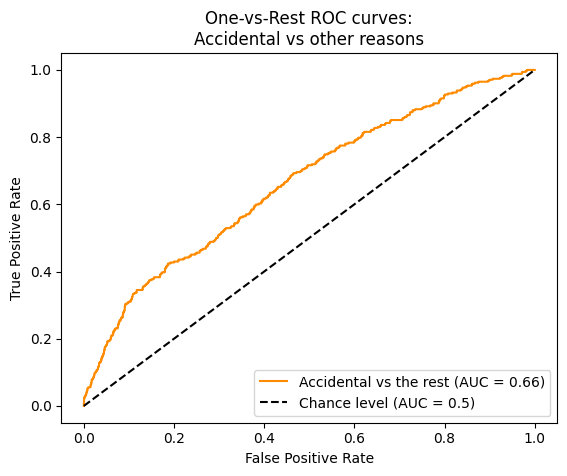

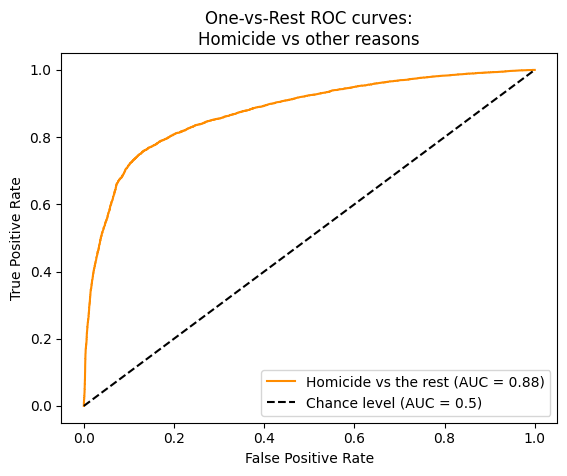

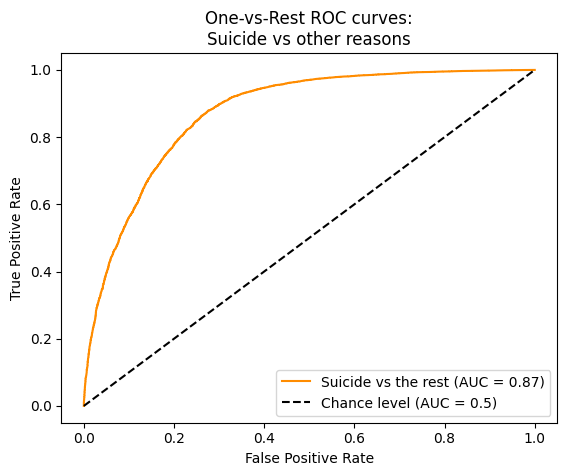

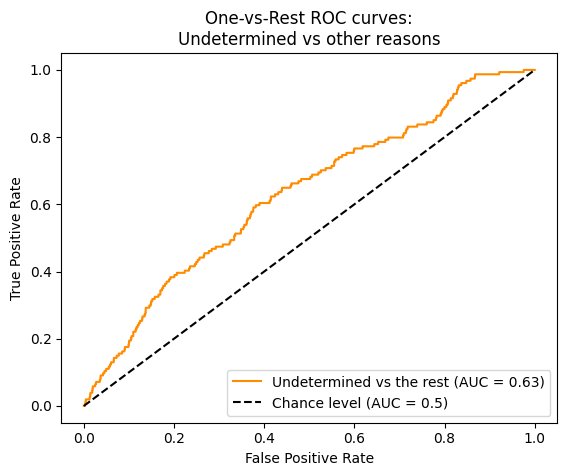

In [33]:
y_pred = best_model_imp.predict(x_test_imp)
y_score = best_model_imp.predict_proba(x_test_imp)  # Predicted probabilities for each class

# Compute accuracy and classification report
accuracy = accuracy_score(y_test_imp, y_pred)
report = classification_report(y_test_imp, y_pred)
print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")

# Binarize the labels for ROC curve calculation
label_binarizer = LabelBinarizer().fit(y_train_imp)
y_onehot_test = label_binarizer.transform(y_test_imp)

# Plot ROC curves for each class (One-vs-Rest)
for reason in label_binarizer.classes_:
    class_id = np.flatnonzero(label_binarizer.classes_ == reason)[0]
    display = RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],  # True labels for that class
        y_score[:, class_id],        # Predicted probabilities for that class
        name=f"{reason} vs the rest",
        color="darkorange",
        plot_chance_level=True,
    )

    # Set ROC curve labels and title
    _ = display.ax_.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"One-vs-Rest ROC curves:\n{reason} vs other reasons",
    )

In [34]:
#coefficients: x_train_imp.columns
acc_model_imp = best_model_imp.coef_[[0]]
hom_model_imp = best_model_imp.coef_[[1]]
suicide_model_imp = best_model_imp.coef_[[2]]
undet_model_imp = best_model_imp.coef_[[3]]

### Logistic Regression on Removed Data ##

In [35]:
warnings.filterwarnings('ignore')
best_model_rem = train_evaluate_lr(x_train_rem,y_train_rem,x_test_rem,y_test_rem)
best_model_rem

Best parameters: {'multi_class': 'ovr', 'penalty': 'none'}
Best cross-validated score: 0.41975686491696185
Test set score: 0.6541660288790244


LogisticRegression(multi_class='ovr', penalty='none', random_state=42)

Accuracy: 0.6541660288790244
Classification Report:
              precision    recall  f1-score   support

  Accidental       0.04      0.31      0.08       331
    Homicide       0.76      0.75      0.76      6692
     Suicide       0.90      0.62      0.73     12425
Undetermined       0.01      0.21      0.03       151

    accuracy                           0.65     19599
   macro avg       0.43      0.47      0.40     19599
weighted avg       0.83      0.65      0.72     19599



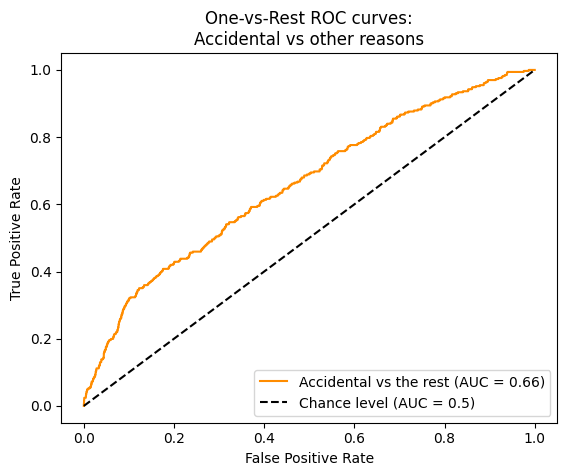

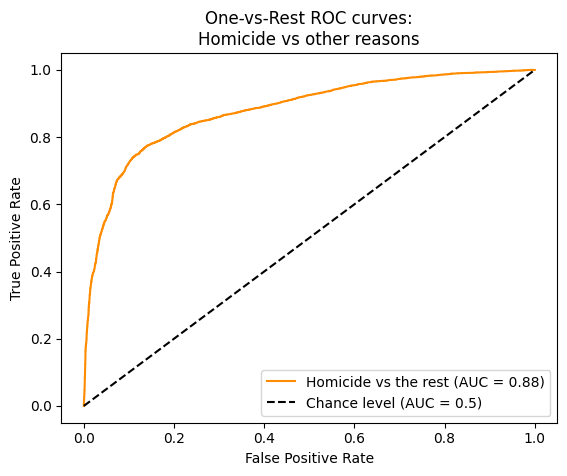

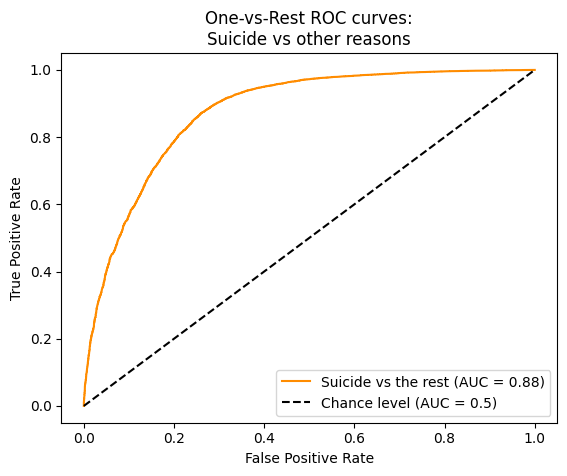

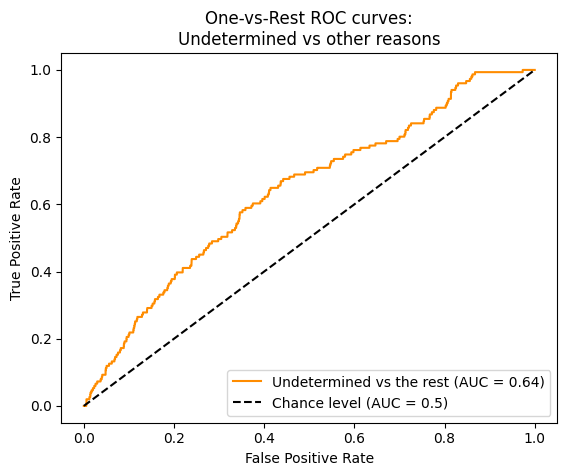

In [36]:
y_pred = best_model_rem.predict(x_test_rem)
y_score = best_model_rem.predict_proba(x_test_rem)  # Predicted probabilities for each class

# Compute accuracy and classification report
accuracy = accuracy_score(y_test_rem, y_pred)
report = classification_report(y_test_rem, y_pred)
print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")

# Binarize the labels for ROC curve calculation
label_binarizer = LabelBinarizer().fit(y_train_rem)
y_onehot_test = label_binarizer.transform(y_test_rem)

# Plot ROC curves for each class (One-vs-Rest)
for reason in label_binarizer.classes_:
    class_id = np.flatnonzero(label_binarizer.classes_ == reason)[0]
    display = RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],  # True labels for that class
        y_score[:, class_id],        # Predicted probabilities for that class
        name=f"{reason} vs the rest",
        color="darkorange",
        plot_chance_level=True,
    )

    # Set ROC curve labels and title
    _ = display.ax_.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"One-vs-Rest ROC curves:\n{reason} vs other reasons",
    )

In [37]:
#coefficients: x_train_rem.columns
acc_model_rem = best_model_rem.coef_[[0]]
hom_model_rem = best_model_rem.coef_[[1]]
suicide_model_rem = best_model_rem.coef_[[2]]
undet_model_rem = best_model_rem.coef_[[3]]

# Baseline Decision Tree

Evaluating Decision Tree on Dataset with Removed Missing Values:
Best Hyperparameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy: 0.7087606510536252
Classification Report:
               precision    recall  f1-score   support

  Accidental       0.04      0.08      0.05       331
    Homicide       0.65      0.66      0.66      6692
     Suicide       0.81      0.76      0.78     12425
Undetermined       0.00      0.01      0.01       151

    accuracy                           0.71     19599
   macro avg       0.38      0.38      0.37     19599
weighted avg       0.74      0.71      0.72     19599



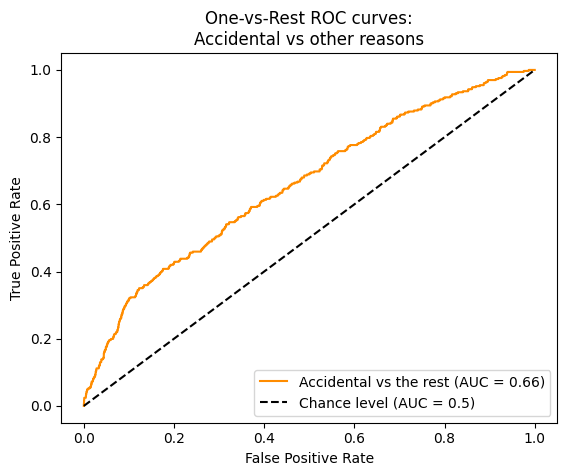

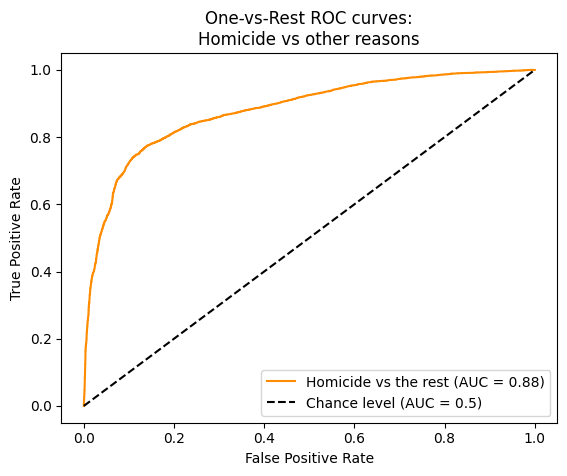

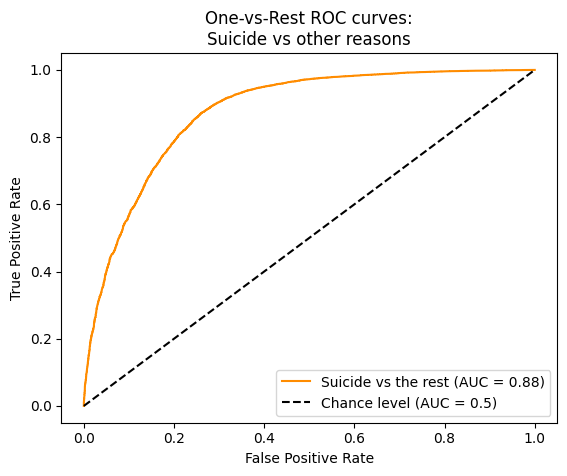

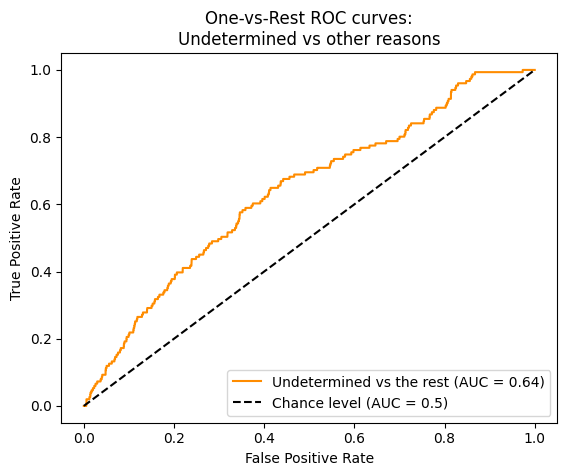

In [38]:
warnings.filterwarnings('ignore')
# Define a function to train and evaluate a baseline decision tree model with ROC curves
def train_evaluate_decision_tree(X_train, y_train, X_test, y_test):
    # Initialize Decision Tree Classifier with default parameters
    clf = DecisionTreeClassifier(random_state=42)
    
    # Define the hyperparameter grid
    param_grid = {
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy']
    }

    # Set up GridSearchCV with F1 scoring
    grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)

    # Fit the model to the training data
    grid_search.fit(X_train, y_train)

    # Get the best estimator from GridSearchCV
    best_clf = grid_search.best_estimator_

    # Make predictions on the test set
    y_pred = best_clf.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    label_binarizer = LabelBinarizer().fit(y_train)
    y_onehot_test = label_binarizer.transform(y_test)
    
    for reason in label_binarizer.classes_:
        class_id = np.flatnonzero(label_binarizer.classes_ == reason)[0]
        display = RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_score[:, class_id],
            name=f"{reason} vs the rest",
            color="darkorange",
            plot_chance_level=True)
        
        _ = display.ax_.set(
            xlabel="False Positive Rate",
            ylabel="True Positive Rate",
            title=f"One-vs-Rest ROC curves:\n{reason} vs other reasons",
            )
    

    print("Best Hyperparameters:", grid_search.best_params_)
    return accuracy, report



# Train and evaluate the model on both datasets
print("Evaluating Decision Tree on Dataset with Removed Missing Values:")
accuracy_remove, report_remove = train_evaluate_decision_tree(x_train_rem, y_train_rem, x_test_rem, y_test_rem)
print(f"Accuracy: {accuracy_remove}")
print("Classification Report:\n", report_remove)



Evaluating Decision Tree on Dataset with Imputed Missing Values:
Best Hyperparameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy: 0.7108015715087505
Classification Report:
               precision    recall  f1-score   support

  Accidental       0.04      0.08      0.05       331
    Homicide       0.66      0.66      0.66      6692
     Suicide       0.81      0.76      0.78     12425
Undetermined       0.00      0.01      0.00       151

    accuracy                           0.71     19599
   macro avg       0.38      0.38      0.37     19599
weighted avg       0.74      0.71      0.72     19599



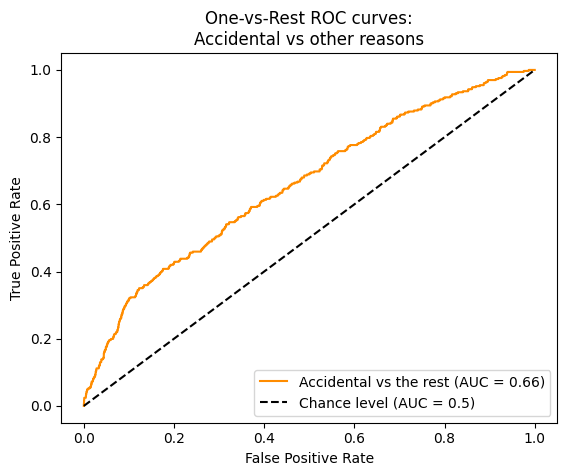

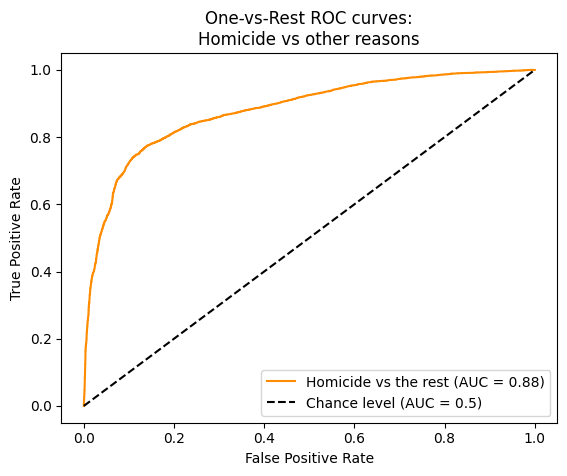

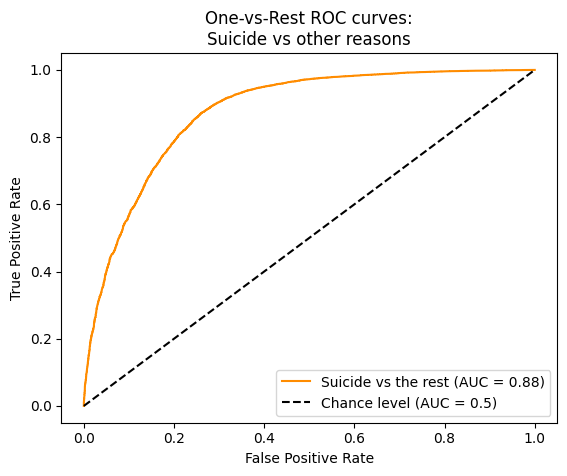

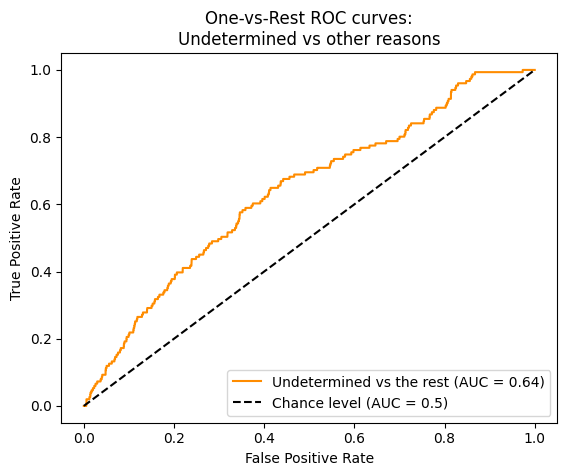

In [39]:
print("\nEvaluating Decision Tree on Dataset with Imputed Missing Values:")
accuracy_impute, report_impute = train_evaluate_decision_tree(x_train_imp, y_train_imp, x_test_rem, y_test_rem)
print(f"Accuracy: {accuracy_impute}")
print("Classification Report:\n", report_impute)

## Random Forest

In [33]:
reason_classes = list(y_train_rem.unique())

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
}

def train_evaluate_rf(x_train, y_train, x_test, y_test, penalise):
    if penalise == True:
        rfc = RandomForestClassifier(random_state=42, class_weight="balanced")
        CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 3, error_score='raise', scoring='f1_weighted')
    else:
        rfc = RandomForestClassifier(random_state=42)
        CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 3, error_score='raise', scoring='f1_macro')

    CV_rfc.fit(x_train, y_train)
    best_rf = CV_rfc.best_estimator_
    best_param = CV_rfc.best_params_
    y_pred = best_rf.predict(x_test)
    y_score = best_rf.predict_proba(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    label_binarizer = LabelBinarizer().fit(y_train)
    y_onehot_test = label_binarizer.transform(y_test)

    for reason in reason_classes:
        class_id = np.flatnonzero(label_binarizer.classes_ == reason)[0]
        display = RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_score[:, class_id],
            name=f"{reason} vs the rest",
            color="darkorange",
            plot_chance_level=True,)
        
        _ = display.ax_.set(
            xlabel="False Positive Rate",
            ylabel="True Positive Rate",
            title=f"One-vs-Rest ROC curves:\n{reason} vs other reasons",
            )
    return best_rf, best_param, accuracy, report

### Random forest classifier on resampled data (removed)


Evaluating Random Forest Classifier on Dataset with Removed Missing Values:
Accuracy: 0.6727894280320424
Classification Report:
               precision    recall  f1-score   support

  Accidental       0.06      0.29      0.09       331
    Homicide       0.78      0.73      0.76      6692
     Suicide       0.88      0.66      0.75     12425
Undetermined       0.01      0.23      0.03       151

    accuracy                           0.67     19599
   macro avg       0.43      0.48      0.41     19599
weighted avg       0.83      0.67      0.74     19599



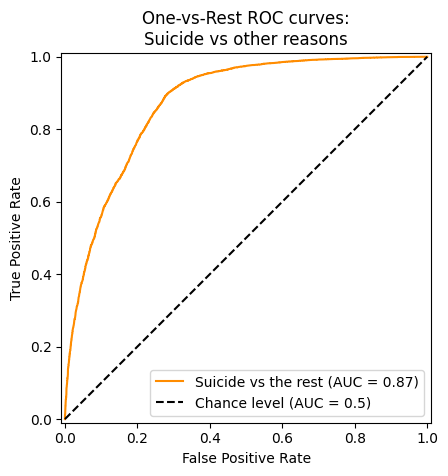

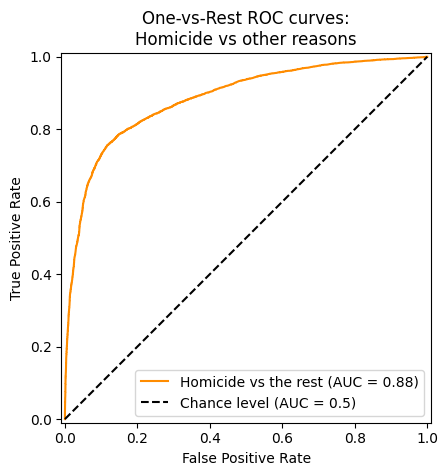

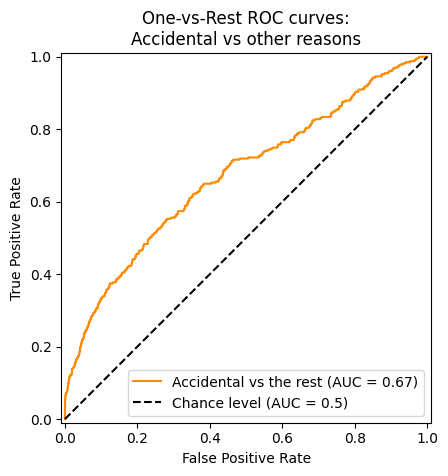

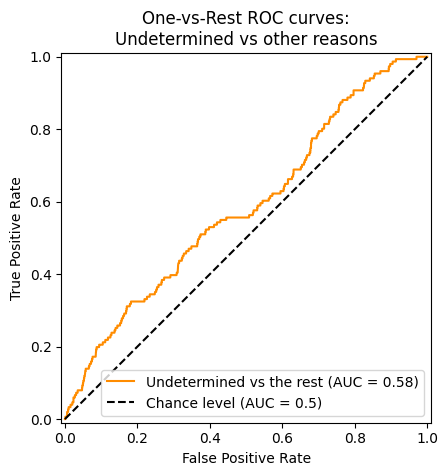

In [ ]:
rf_rem, best_param_rem, accuracy_rem, report_rem = train_evaluate_rf(x_train_rem, y_train_rem, x_test_rem, y_test_rem, False)

print("\nEvaluating Random Forest Classifier on Dataset with Removed Missing Values:")
print(f"Accuracy: {accuracy_rem}")
print("Classification Report:\n", report_rem)

### Random forest classifier on resampled data


Evaluating Random Forest Classifier on Dataset with Imputed Missing Values:
Accuracy: 0.6722791979182612
Classification Report:
               precision    recall  f1-score   support

  Accidental       0.06      0.28      0.10       331
    Homicide       0.78      0.73      0.76      6692
     Suicide       0.88      0.66      0.75     12425
Undetermined       0.01      0.25      0.03       151

    accuracy                           0.67     19599
   macro avg       0.43      0.48      0.41     19599
weighted avg       0.83      0.67      0.74     19599



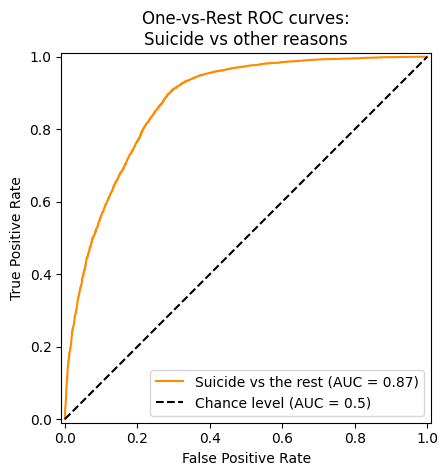

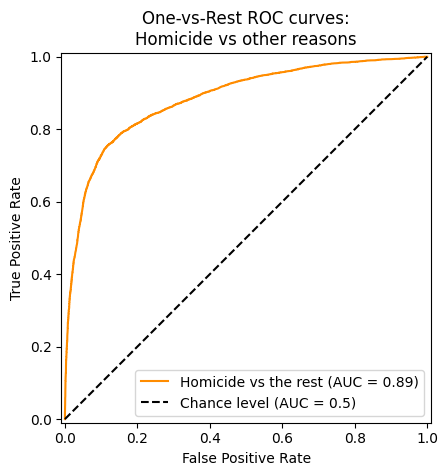

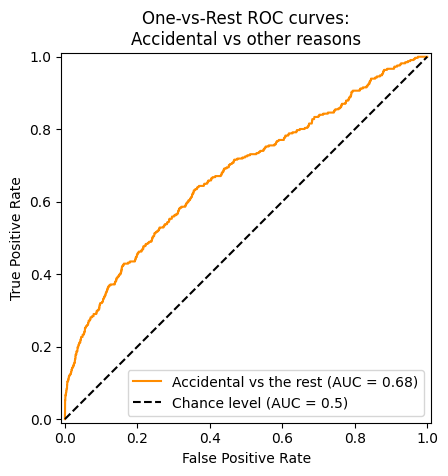

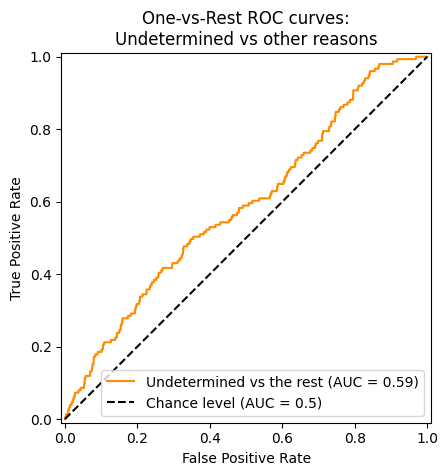

In [ ]:
rf_imp, best_param_imp, accuracy_imp, report_imp= train_evaluate_rf(x_train_imp, y_train_imp, x_test_rem, y_test_rem, False)

print("\nEvaluating Random Forest Classifier on Dataset with Imputed Missing Values:")
print(f"Accuracy: {accuracy_imp}")
print("Classification Report:\n", report_imp)

### Random Forest with class weights on original imputed data


Evaluating Random Forest Classifier with class weights on Dataset with Imputed Missing Values:
Accuracy: 0.7245267615694678
Classification Report:
               precision    recall  f1-score   support

  Accidental       0.06      0.24      0.10       331
    Homicide       0.75      0.76      0.75      6692
     Suicide       0.88      0.73      0.79     12425
Undetermined       0.02      0.13      0.03       151

    accuracy                           0.72     19599
   macro avg       0.43      0.46      0.42     19599
weighted avg       0.81      0.72      0.76     19599



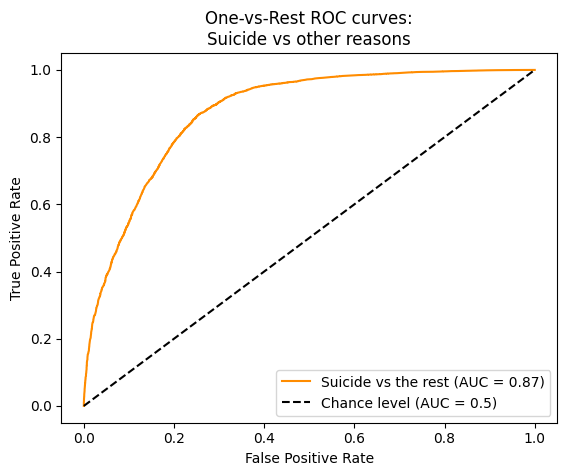

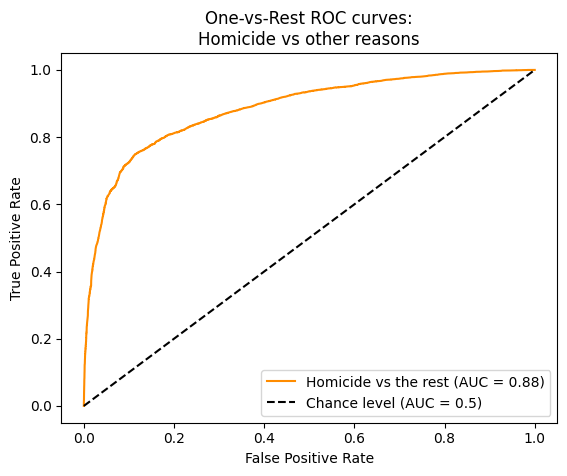

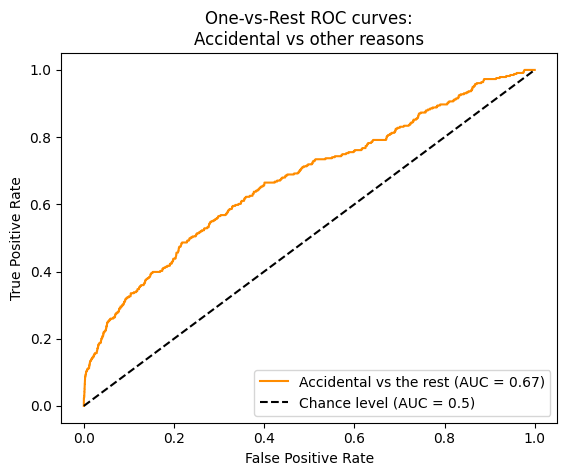

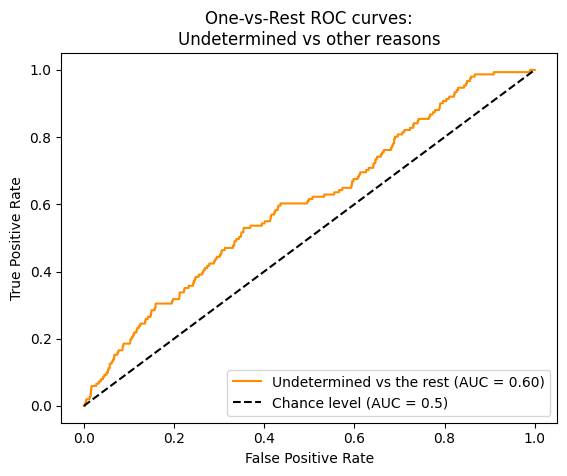

In [34]:
rf_imb, best_param_imb, accuracy_imb, report_imb = train_evaluate_rf(x_train_imb, y_train_imb, x_test_rem, y_test_rem, True)

print("\nEvaluating Random Forest Classifier with class weights on Dataset with Imputed Missing Values:")
print(f"Accuracy: {accuracy_imb}")
print("Classification Report:\n", report_imb)

## XGBoost

In [43]:
#replacing our labels with [0 1 2 3] for XGBoost because it literally refuses to take the categorical labels
labels_numeric = {"Accidental": 0, "Homicide": 1,"Suicide":2,"Undetermined":3}

y_train_rem_num = y_train_rem.replace(labels_numeric)
y_test_rem_num = y_test_rem.replace(labels_numeric)

y_train_imp_num = y_train_imp.replace(labels_numeric)
y_test_imp_num = y_test_imp.replace(labels_numeric)

y_train_imb_num = y_train_imb.replace(labels_numeric)


In [ ]:
# Define a function to train and evaluate a XGBoost model

xgb_reason_classes = list(y_train_rem_num.unique())
param_grid_xgb = {
    'max_depth': [15, 18, 20],
    'learning_rate': [0.1, 0.3, 0.6],
    'subsample': [0.5, 0.7, 1]
}

classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train_imb
)

def train_evaluate_xgboost(X_train, y_train, X_test, y_test, penalise):
    # Initialize XGBoost Classifier with default parameters
    xgbc = xgb.XGBClassifier()
    CV_xgbc = GridSearchCV(xgbc, param_grid_xgb, cv= 3, scoring='f1', n_jobs=-1)
    
    if penalise ==True:
        CV_xgbc.fit(X_train, y_train, sample_weight = classes_weights)

    else:
        CV_xgbc.fit(X_train, y_train)
    best_param = CV_xgbc.best_params_
    y_pred = CV_xgbc.predict(X_test)
    y_score = CV_xgbc.fit(X_train, y_train).predict_proba(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    label_binarizer = LabelBinarizer().fit(y_train)
    y_onehot_test = label_binarizer.transform(y_test)
    
    for reason in xgb_reason_classes:
        class_id = np.flatnonzero(label_binarizer.classes_ == reason)[0]
        display = RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_score[:, class_id],
            name=f"{reason} vs the rest",
            color="darkorange",
            plot_chance_level=True)
        
        _ = display.ax_.set(
            xlabel="False Positive Rate",
            ylabel="True Positive Rate",
            title=f"One-vs-Rest ROC curves:\n{reason} vs other reasons",
            )
    

    return CV_xgbc, best_param, accuracy, report

### XGBoost classifier on resampled data (removed)

Evaluating XGBoost on Dataset with Removed Missing Values:


c:\Users\Gan Wan Yi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\Gan Wan Yi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Accuracy: 0.75177304964539
Classification Report:
               precision    recall  f1-score   support

           0       0.04      0.08      0.05       331
           1       0.73      0.71      0.72      6692
           2       0.84      0.80      0.82     12425
           3       0.00      0.01      0.00       151

    accuracy                           0.75     19599
   macro avg       0.40      0.40      0.40     19599
weighted avg       0.78      0.75      0.77     19599

Best Parameters: {'learning_rate': 0.1, 'max_depth': 15, 'subsample': 0.5}


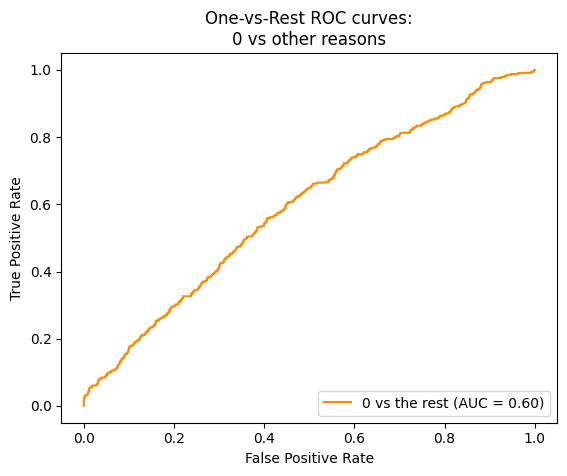

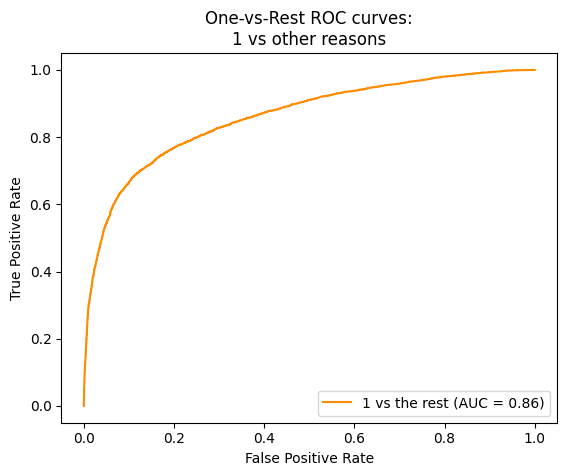

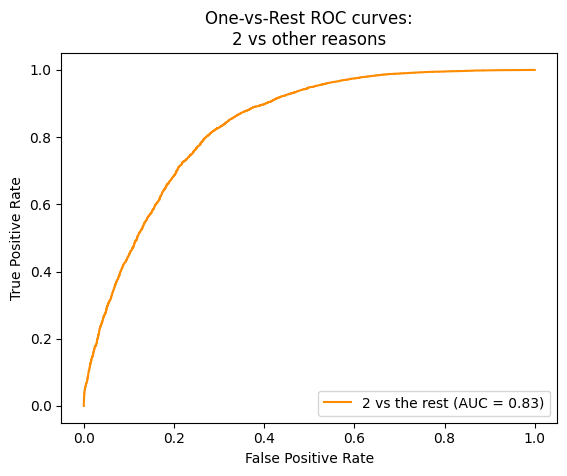

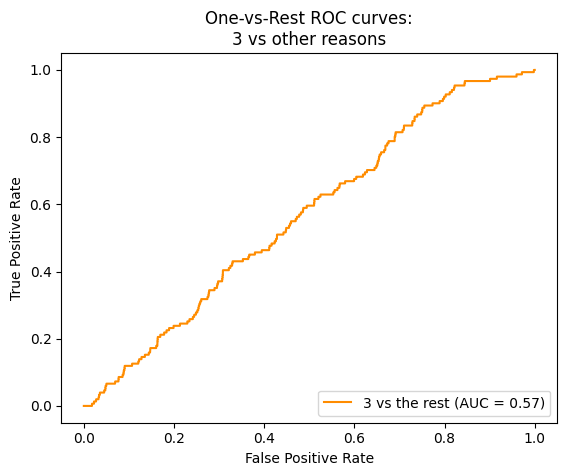

In [40]:
print("Evaluating XGBoost on Dataset with Removed Missing Values:")
xgb_model_rem, xgb_best_param_remove, xgb_accuracy_remove, xgb_report_remove = train_evaluate_xgboost(x_train_rem, y_train_rem_num, x_test_rem, y_test_rem_num, False)
print(f"Accuracy: {xgb_accuracy_remove}")
print("Classification Report:\n", xgb_report_remove)
print("Best Parameters:", xgb_best_param_remove)

### XGBoost classifier on resampled data (imputed)

Evaluating XGBoost on Dataset with Imputed Missing Values:


c:\Users\Gan Wan Yi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\Gan Wan Yi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Accuracy: 0.7543242002142967
Classification Report:
               precision    recall  f1-score   support

           0       0.04      0.09      0.05       331
           1       0.74      0.71      0.72      6692
           2       0.84      0.81      0.82     12425
           3       0.00      0.01      0.00       151

    accuracy                           0.75     19599
   macro avg       0.40      0.40      0.40     19599
weighted avg       0.78      0.75      0.77     19599

Best Parameters: {'learning_rate': 0.1, 'max_depth': 15, 'subsample': 0.5}


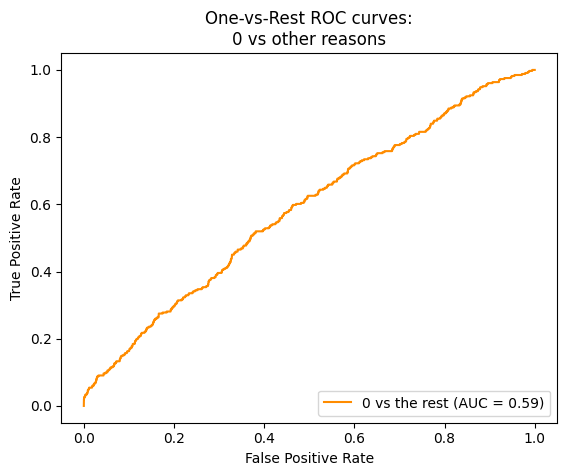

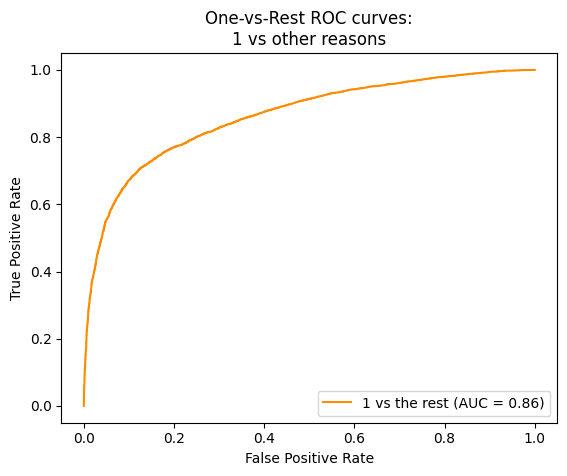

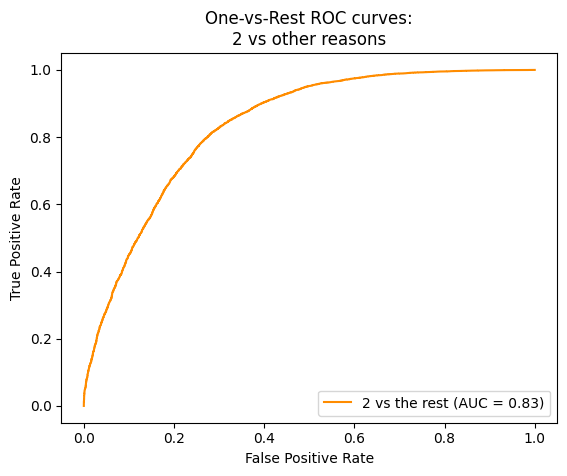

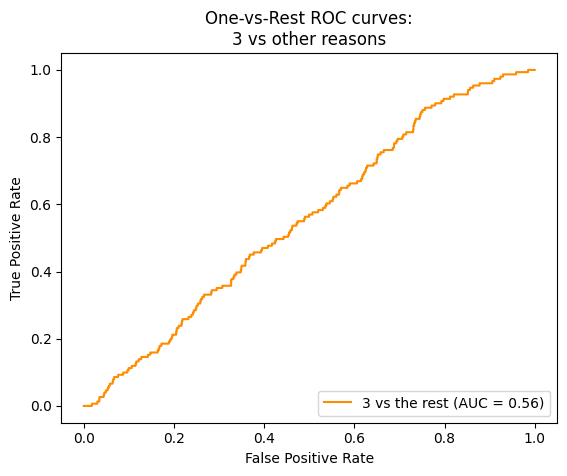

In [41]:
print("Evaluating XGBoost on Dataset with Imputed Missing Values:")
xgb_model_imp, xgb_best_param_impute, xgb_accuracy_impute, xgb_report_impute = train_evaluate_xgboost(x_train_imp, y_train_imp_num, x_test_rem, y_test_rem_num, False)
print(f"Accuracy: {xgb_accuracy_impute}")
print("Classification Report:\n", xgb_report_impute)
print("Best Parameters:", xgb_best_param_impute)

### XGBoost with class weights on original imputed data

Evaluating XGBoost on class weights on original imputed data:


c:\Users\Gan Wan Yi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\Gan Wan Yi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Accuracy: 0.7673350681157202
Classification Report:
               precision    recall  f1-score   support

           0       0.04      0.08      0.05       331
           1       0.74      0.74      0.74      6692
           2       0.85      0.81      0.83     12425
           3       0.00      0.01      0.00       151

    accuracy                           0.77     19599
   macro avg       0.41      0.41      0.41     19599
weighted avg       0.79      0.77      0.78     19599

Best Parameters: {'learning_rate': 0.1, 'max_depth': 15, 'subsample': 0.5}


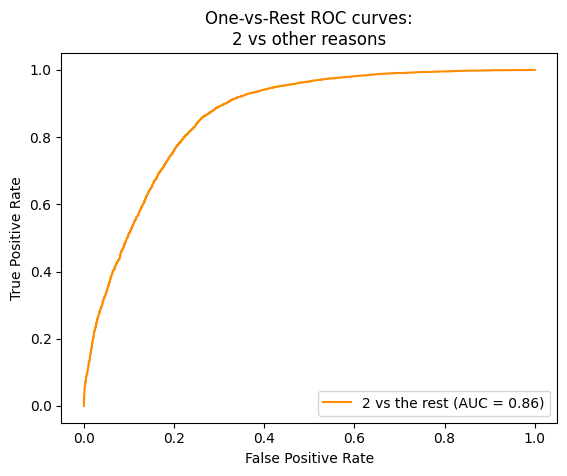

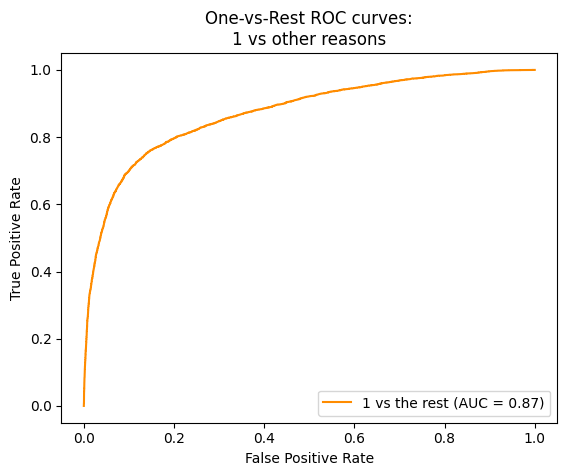

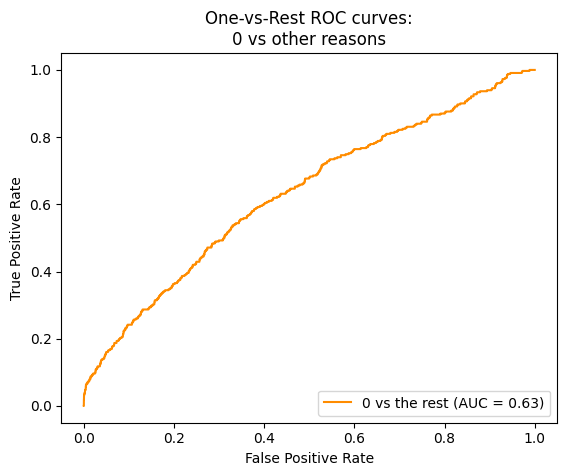

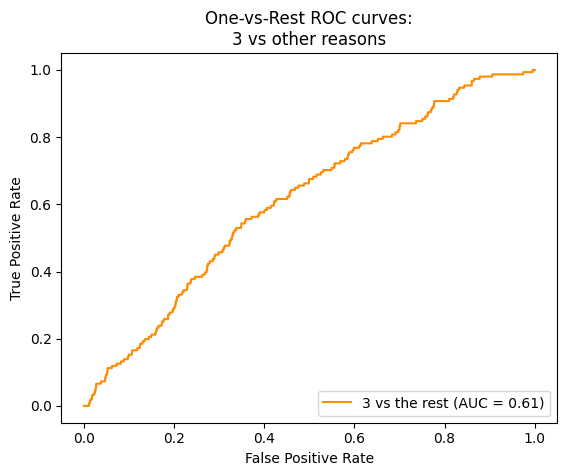

In [25]:
print("Evaluating XGBoost on class weights on original imputed data:")
xgb_model_imb, xgb_best_param_imb, xgb_accuracy_imb, xgb_report_imb = train_evaluate_xgboost(x_train_imb, y_train_imb_num, x_test_rem, y_test_rem_num, True)
print(f"Accuracy: {xgb_accuracy_imb}")
print("Classification Report:\n", xgb_report_imb)
print("Best Parameters:", xgb_best_param_imb)

### XGBoost Error Analysis: Class weights on Dataset with Imputed Missing Data

In [27]:
xgb_model_imb.fit(x_train_imb, y_train_imb_num)
xgb_y_pred = xgb_model_imb.predict(x_test_rem)
xgb_y_score = xgb_model_imb.predict_proba(x_test_rem)
    
xgb_label_binarizer = LabelBinarizer().fit(y_train_imb_num)
xgb_y_onehot_test = xgb_label_binarizer.transform(y_test_rem_num)
epsilon = 1e-10

# Calculate cross-entropy loss (log-loss) for each instance
xgb_log_losses = -np.sum(xgb_y_onehot_test * np.log(xgb_y_score + epsilon), axis=1)
                     
xgb_reason_classes = xgb_label_binarizer.classes_
xgb_log_loss_df = df_test_final_rem.copy()
xgb_log_loss_df ['log_loss']  = xgb_log_losses
xgb_log_loss_df ['reason_pred'] = xgb_y_pred
xgb_y_score_df = pd.DataFrame(xgb_y_score, columns=xgb_reason_classes)
xgb_log_loss_df  = pd.concat([xgb_log_loss_df .reset_index(drop=True), xgb_y_score_df], axis=1)
                         
#xgb_best_model = xgb_model_imb.best_estimator_
#xgb_importances = xgb_best_model.get_booster().get_score(importance_type='gain')
xgb_importances = xgb_model_imb.best_estimator_.feature_importances_

xgb_importance_df = pd.DataFrame({
    'Feature': x_test_rem.columns,
    'Importance': xgb_importances
})

xgb_importance_df = xgb_importance_df.sort_values(by='Importance', ascending=False)

xgb_result = permutation_importance(xgb_model_imb, x_test_rem, y_test_rem_num, n_repeats=10, scoring='f1_weighted')

xgb_permutation_importance_df = pd.DataFrame({'Feature': x_test_rem.columns, 'Importance': xgb_result.importances_mean})
xgb_permutation_importance_df = xgb_permutation_importance_df.sort_values(by='Importance', ascending=False)

c:\Users\Gan Wan Yi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
  warnings.warn(


In [29]:
#Log loss in descending order
pd.set_option("display.max_columns", None)
xgb_log_loss_df.sort_values(by='log_loss', ascending=False).head(10)

Farm  Home  Industrial/construction  Other specified  \
10914     0     1                        0                0   
14729     0     0                        0                0   
3332      0     0                        0                0   
12731     0     0                        0                1   
1551      0     1                        0                0   
3496      0     0                        0                1   
738       0     0                        0                1   
6784      0     1                        0                0   
4481      0     0                        0                0   
4750      0     1                        0                0   

       Other unspecified  Residential institution  School/instiution  Sports  \
10914                  0                        0                  0       0   
14729                  0                        0                  0       0   
3332                   1                        0                  0       0   
12731                  0                        0                  0       0   
1551                   0                        0                  0       0   
3496                   0                        0                  0       0   
738                    0                        0                  0       0   
6784                   0                        0                  0       0   
4481                   0                        0                  0       0   
4750                   0                        0                  0       0   

       Street  Trade/service area  ...  Month  Education   Age  \
10914       0                   0  ...      9          2  84.0   
14729       1                   0  ...     10          1  23.0   
3332        0                   0  ...      6          2  20.0   
12731       0                   0  ...      5          2  88.0   
1551        0                   0  ...     10          3  69.0   
3496        0                   0  ...      6          2  49.0   
738         0                   0  ...      5          0  24.0   
6784        0                   0  ...      4          2  68.0   
4481        1                   0  ...      4          1  19.0   
4750        0                   0  ...      9          0  79.0   

       Police involvement  log_loss  reason_pred         0         1  \
10914                   0  8.077185            2  0.001757  0.001344   
14729                   0  7.560802            1  0.001046  0.991568   
3332                    0  7.084809            1  0.000838  0.985659   
12731                   0  6.807481            2  0.001499  0.001105   
1551                    0  6.745947            2  0.001176  0.003185   
3496                    0  6.742611            2  0.005639  0.029591   
738                     0  6.727843            1  0.001197  0.977535   
6784                    0  6.549353            2  0.003867  0.022919   
4481                    0  6.497047            1  0.000793  0.997309   
4750                    0  6.481444            2  0.001322  0.003486   

              2         3  
10914  0.996589  0.000311  
14729  0.006866  0.000520  
3332   0.010306  0.003198  
12731  0.996220  0.001175  
1551   0.995000  0.000639  
3496   0.963591  0.001180  
738    0.019214  0.002053  
6784   0.971783  0.001431  
4481   0.001508  0.000390  
4750   0.993661  0.001532  

[10 rows x 29 columns]

In [29]:
#Features that contribute most to misclassification
xgb_permutation_importance_df.head(10)

,Feature,Importance
14,White,0.106636
20,Age,0.038668
11,Black,0.037267
19,Education,0.013212
8,Street,0.005951
15,Female,0.004970
1,Home,0.002891
12,Hispanic,0.001829
13,Native American/Native Alaskan,0.000206
6,School/instiution,0.000138


Based on the permutation importance, it appears that Age and Race have a bigger influence on the model predictions. This aligns with our data analysis findings.

## Future improvement

### Bagging with estimator set to RandomForest

In [62]:
# the best params are {'max_features': 0.75, 'max_samples': 0.75, 'n_estimators': 50}
#param_grid = { 
    #'n_estimators': [10, 50],
    #'max_samples': [0.75, 1.0],
    #'max_features': [0.75, 1.0]
#}
# the above chunk is commented out because we already found out the best params so to save time UNCOMMENT OUT LATER THO
param_grid = { 
    'n_estimators': [50],
    'max_samples': [0.75],
    'max_features': [0.75]
}


reason_classes=list(y_train_imp.unique())

def train_evaluate_bagging(x_train, y_train, x_test, y_test, penalise):
    estimator = RandomForestClassifier(random_state=42, class_weight="balanced" if penalise else None)
    bagging_clf = BaggingClassifier(estimator=estimator, random_state=42)
    
    CV_bagging = GridSearchCV(estimator=bagging_clf, param_grid=param_grid, cv=3, error_score='raise')
    CV_bagging.fit(x_train, y_train)
    best_param = CV_bagging.best_params_
    y_pred = CV_bagging.predict(x_test)
    y_score = CV_bagging.predict_proba(x_test)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    label_binarizer = LabelBinarizer().fit(y_train)
    y_onehot_test = label_binarizer.transform(y_test)
    
    for reason in reason_classes:
        class_id = np.flatnonzero(label_binarizer.classes_ == reason)[0]
        display = RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_score[:, class_id],
            name=f"{reason} vs the rest",
            color="darkorange",
            plot_chance_level=True
        )
        
        _ = display.ax_.set(
            xlabel="False Positive Rate",
            ylabel="True Positive Rate",
            title=f"One-vs-Rest ROC curves:\n{reason} vs other reasons",
        )
    
    return best_param, accuracy, report


Evaluating  Bagging with Random Forest Classifier as Estimator with class weights on Original Dataset with Imputed Missing Values:
Accuracy: 0.8257053931323026
Classification Report:
               precision    recall  f1-score   support

  Accidental       0.24      0.03      0.05       331
    Homicide       0.79      0.74      0.76      6692
     Suicide       0.85      0.90      0.87     12425
Undetermined       0.00      0.00      0.00       151

    accuracy                           0.83     19599
   macro avg       0.47      0.42      0.42     19599
weighted avg       0.81      0.83      0.82     19599



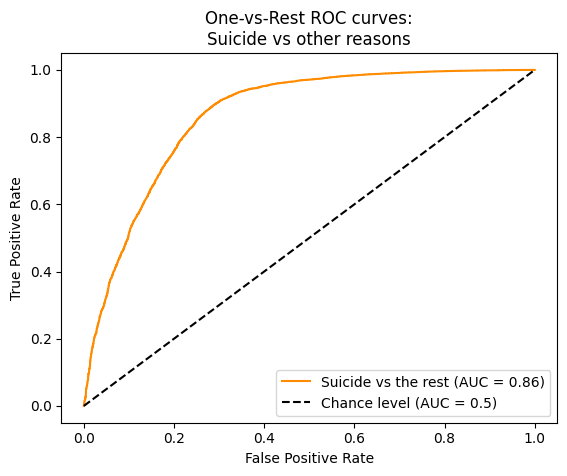

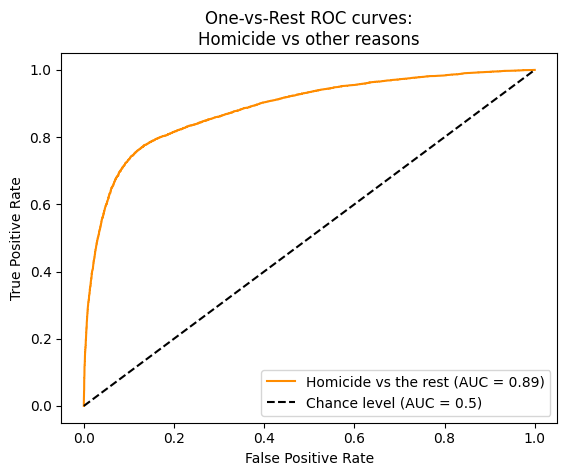

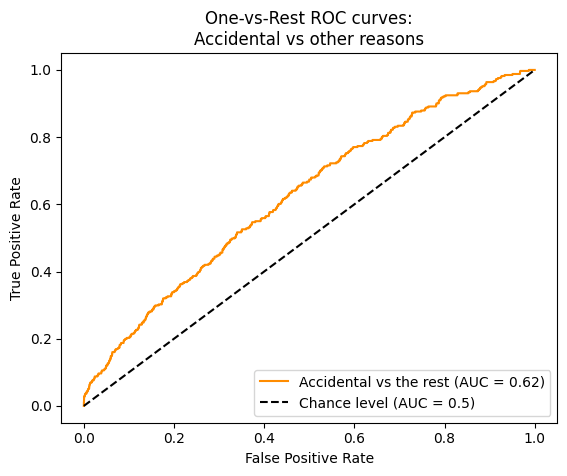

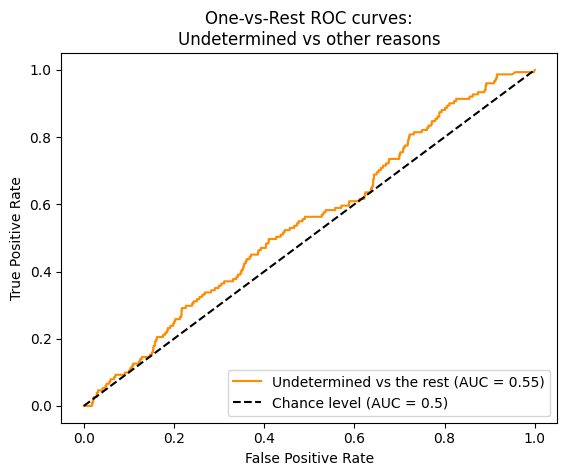

In [63]:
best_param_imp, accuracy_imp, report_imp = train_evaluate_bagging(x_train_imb, y_train_imb, x_test_rem, y_test_rem, True)

print("\nEvaluating  Bagging with Random Forest Classifier as Estimator with class weights on Original Dataset with Imputed Missing Values:")
print(f"Accuracy: {accuracy_imp}")
print("Classification Report:\n", report_imp)